2024-08-23 10:14:20.070526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 10:14:20.084466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 10:14:20.100620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 10:14:20.105376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 10:14:20.116518: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/60


I0000 00:00:1724388264.289845  315196 service.cc:146] XLA service 0x74a3b0013ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724388264.289886  315196 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-08-23 10:14:24.338664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-23 10:14:24.577400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1692 - loss: 5.7343 

I0000 00:00:1724388267.052072  315196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.1671 - loss: 5.6715 - val_accuracy: 0.1881 - val_loss: 4.5399 - learning_rate: 5.0000e-04
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2177 - loss: 4.8135 - val_accuracy: 0.2288 - val_loss: 4.3883 - learning_rate: 5.0000e-04
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2176 - loss: 4.5385 - val_accuracy: 0.2382 - val_loss: 4.2564 - learning_rate: 5.0000e-04
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2247 - loss: 4.3318 - val_accuracy: 0.2696 - val_loss: 4.1335 - learning_rate: 5.0000e-04
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2536 - loss: 4.1567 - val_accuracy: 0.3135 - val_loss: 4.0257 - learning_rate: 5.0000e-04
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2562 - loss: 4.0637 - val_accuracy: 0.3323 - val_loss: 3.9172 - learning_rate: 5.0000e-04
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2906 - loss: 3.8904 -

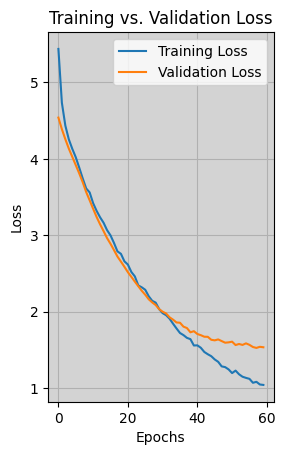

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load your dataset
df = pd.read_csv('/home/devnath/MOTIF_18_Aug/dataset/motif_standardized_dataset.csv')

# Assume 'family' is the column with the target variable
X = df.drop(columns=['family'])
y = df['family']

# Convert labels to categorical (one-hot encoding)
num_classes = len(y.unique())
y = to_categorical(y, num_classes=num_classes)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input data for 1D CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Extract the timesteps and features from the shape of X_train
timesteps = X_train.shape[1]  # Length of each input sequence
features = X_train.shape[2]   # Number of features per timestep

# Adjust model architecture
model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(timesteps, features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn1d_multiclass_classifier.keras', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

# Set grid and background color
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

plt.show()


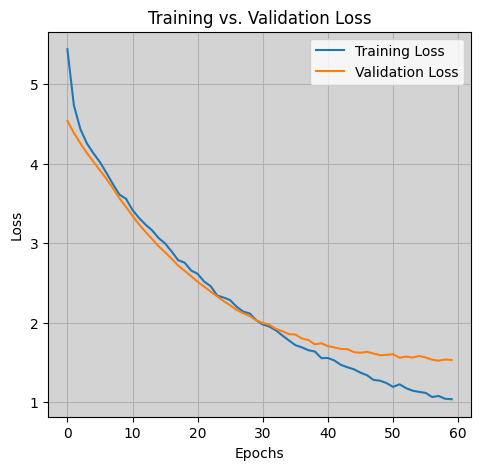

In [2]:
# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

# Set grid and background color
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

plt.show()

In [9]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 39, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 39, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 19, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 17, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 6, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,248 (489.25 KB)

 Trainable params: 41,674 (162.79 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 83,350 (325.59 KB)

In [3]:
# Save the trained model
model.save('/home/devnath/MOTIF_18_Aug/model_save/1dcnn_base_classfier.h5')

In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
dcnn1_model = load_model('/home/devnath/MOTIF_18_Aug/model_save/1dcnn_base_classfier.h5')


In [6]:
dcnn_base_1 = dcnn1_model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [7]:
dcnn_base_1.shape

(399, 10)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load your dataset
df = pd.read_csv('/home/devnath/MOTIF_18_Aug/dataset/motif_standardized_dataset.csv')

# Assume 'family' is the column with the target variable
X = df.drop(columns=['family'])
y = df['family']

# Convert labels to categorical (one-hot encoding)
num_classes = len(y.unique())
y = to_categorical(y, num_classes=num_classes)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input data for 1D CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Extract the timesteps and features from the shape of X_train
timesteps = X_train.shape[1]  # Length of each input sequence
features = X_train.shape[2]   # Number of features per timestep

# Adjust model architecture
model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(timesteps, features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn1d_multiclass_classifier.keras', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


# plt.figure(figsize=(12, 5))
# # Plot loss
# # plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training vs. Validation Loss')

# # Set grid and background color
# plt.grid(True)
# plt.gca().set_facecolor('lightgrey')

# plt.show()

Epoch 1/50


/home/devnath/anaconda3/envs/ember_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.1513 - loss: 5.9114 - val_accuracy: 0.2414 - val_loss: 4.5402 - learning_rate: 5.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2015 - loss: 4.7450 - val_accuracy: 0.2539 - val_loss: 4.4302 - learning_rate: 5.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1954 - loss: 4.4921 - val_accuracy: 0.2884 - val_loss: 4.2873 - learning_rate: 5.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2385 - loss: 4.2620 - val_accuracy: 0.3135 - val_loss: 4.1583 - learning_rate: 5.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2344 - loss: 4.1034 - val_accuracy: 0.3574 - val_loss: 4.0212 - learning_rate: 5.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2739 - loss: 3.8959 - val_accuracy: 0.3762 - val_loss: 3.8994 - learning_rate: 5.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2882 - loss: 3.8213 -

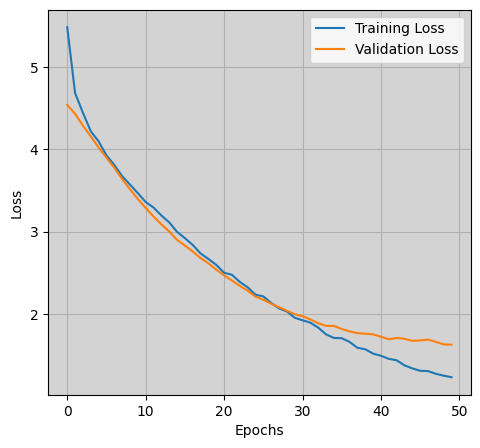

In [4]:
plt.figure(figsize=(12, 5))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.title('Training vs. Validation Loss')

# Set grid and background color
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

plt.show()

In [1]:
!nvidia-smi

Sat Aug 24 21:38:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 00000000:47:00.0 Off |                  Off |
| 41%   39C    P8              15W / 140W |    513MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!kill 622897

2024-08-24 21:53:20.848800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-24 21:53:20.863876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 21:53:20.881192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 21:53:20.885612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 21:53:20.898008: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/50


I0000 00:00:1724516605.069446  636888 service.cc:146] XLA service 0x7a2cb8019720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724516605.069478  636888 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-08-24 21:53:25.120245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-24 21:53:25.357974: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1317 - loss: 5.9757 

I0000 00:00:1724516607.974748  636888 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.1348 - loss: 5.8612 - val_accuracy: 0.2226 - val_loss: 4.5685 - learning_rate: 5.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1627 - loss: 5.0404 - val_accuracy: 0.2006 - val_loss: 4.4411 - learning_rate: 5.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2241 - loss: 4.4874 - val_accuracy: 0.1787 - val_loss: 4.3248 - learning_rate: 5.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2129 - loss: 4.3400 - val_accuracy: 0.2257 - val_loss: 4.2069 - learning_rate: 5.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2462 - loss: 4.1460 - val_accuracy: 0.2445 - val_loss: 4.0845 - learning_rate: 5.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2397 - loss: 4.0481 - val_accuracy: 0.2884 - val_loss: 3.9658 - learning_rate: 5.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2911 - loss: 3.8514 -

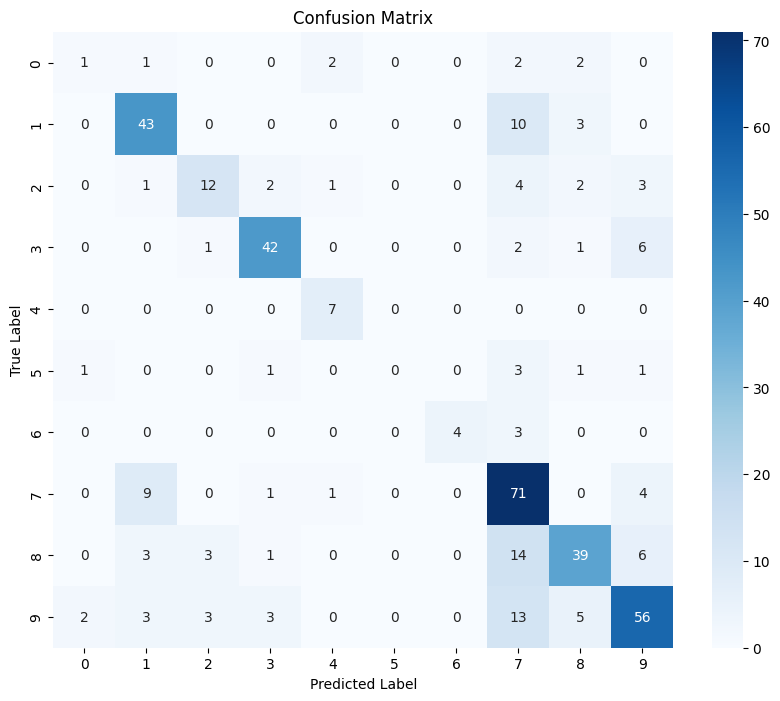

Accuracy: 68.92%
Precision: 68.75%
Recall: 68.92%
F1 Score: 67.91%


/home/devnath/anaconda3/envs/ember_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Load your dataset
df = pd.read_csv('/home/devnath/MOTIF_18_Aug/dataset/motif_standardized_dataset.csv')

# Assume 'family' is the column with the target variable
X = df.drop(columns=['family'])
y = df['family']

# Convert labels to categorical (one-hot encoding)
num_classes = len(y.unique())
y = to_categorical(y, num_classes=num_classes)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input data for 1D CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Extract the timesteps and features from the shape of X_train
timesteps = X_train.shape[1]  # Length of each input sequence
features = X_train.shape[2]   # Number of features per timestep

# Adjust model architecture
model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(timesteps, features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn1d_multiclass_classifier.keras', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')


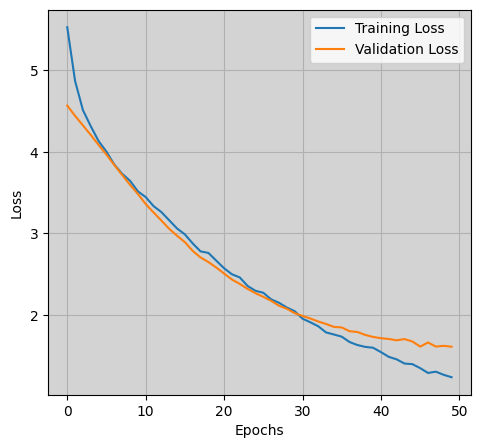

In [2]:
plt.figure(figsize=(12, 5))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.title('Training vs. Validation Loss')

# Set grid and background color
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

plt.show()

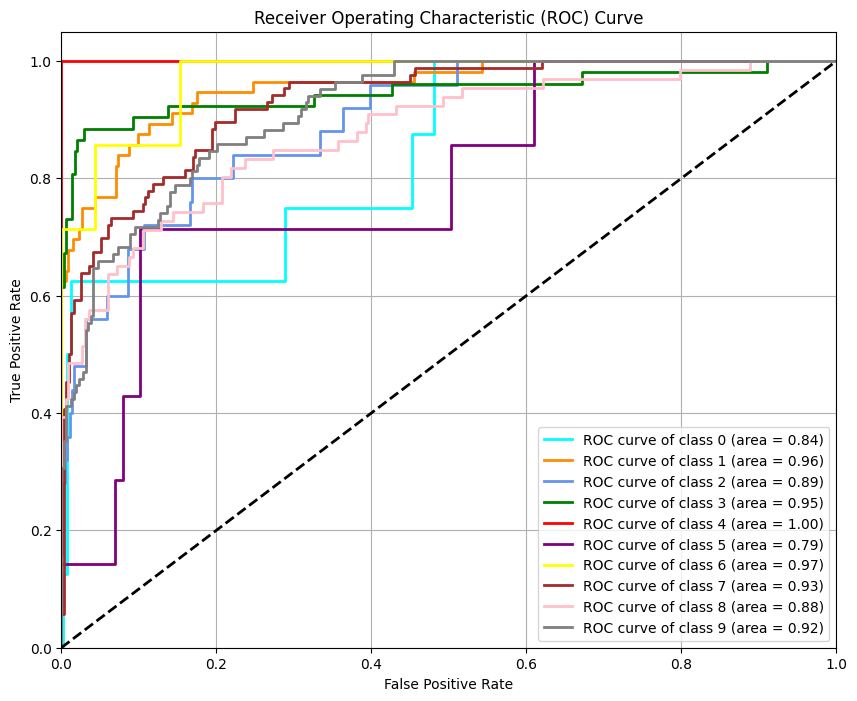

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for ROC computation (One-vs-Rest approach)
y_test_binarized = label_binarize(y_true, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'grey'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line representing random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,248 (489.25 KB)

 Trainable params: 41,674 (162.79 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 83,350 (325.59 KB)